### 直到机器学习之前的步骤都与问题而相同，也就是提取特征的过程

In [1]:
import pandas as pd

file_path = "附件1 (Attachment 1).xlsx"
data = pd.read_excel(file_path)
data.head()

,电磁辐射 (EMR),时间 (time),类别 (class)
0,40.00,2019-01-09 05:01:29,D/E
1,43.59,2019-01-09 05:01:29,D/E
2,35.00,2019-01-09 05:02:00,D/E
3,34.00,2019-01-09 05:02:31,D/E
4,36.00,2019-01-09 05:03:02,D/E


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sheet1_data = pd.read_excel(file_path, sheet_name=0)  
sheet2_data = pd.read_excel(file_path, sheet_name=1) 

In [4]:
def calculate_features(data, value_col, window_size=3):
    features_df = pd.DataFrame()
    features_df['前兆信号'] = (data['类别 (class)'] == 'B').astype(int)
    
    # 基本滚动窗口特征
    features_df['rolling_mean'] = data[value_col].rolling(window=window_size).mean()
    features_df['rolling_std'] = data[value_col].rolling(window=window_size).std()
    features_df['rolling_var'] = data[value_col].rolling(window=window_size).var()
    
    # 指数平滑特征
    features_df['ewm_mean'] = data[value_col].ewm(span=window_size).mean()
    features_df['ewm_std'] = data[value_col].ewm(span=window_size).std()
    
    # 拉格特征
    features_df['lag_1'] = data[value_col].shift(1)
    features_df['lag_2'] = data[value_col].shift(2)
    
    # 季节性特征 - 时间维度
    data['时间 (time)'] = pd.to_datetime(data['时间 (time)'])  # 确保时间列的数据类型为 datetime
    features_df['day_of_week'] = data['时间 (time)'].dt.weekday
    features_df['is_weekend'] = (features_df['day_of_week'] >= 5).astype(int)
    
    # 趋势特征
    features_df['trend'] = data[value_col].diff().rolling(window=window_size).mean()
    
    # 周期性特征
    features_df['seasonality'] = data[value_col].diff(7)  # 周期为7天
    
    # 窗口统计特征
    features_df['long_rolling_mean'] = data[value_col].rolling(window=7).mean()
    features_df['short_rolling_mean'] = data[value_col].rolling(window=3).mean()
    
    # 差分特征
    features_df['diff_1'] = data[value_col].diff()
    features_df['diff_2'] = data[value_col].diff().diff()
    
    # 连接原始数据和衍生特征
    features_df.index = data.index
    result = pd.concat([data, features_df], axis=1)
    return result

# 计算每个工作表的特征，并保存结果
sheet1_features = calculate_features(sheet1_data, '电磁辐射 (EMR)')
sheet2_features = calculate_features(sheet2_data, '声波强度 (AE)')


### 1. 数据预处理

#### 数据分割
将特征数据集 \(X\) 和目标数据集 \(y\) 分割为训练集和测试集。
$$
(X_{\text{train}}, X_{\text{test}}, y_{\text{train}}, y_{\text{test}}) = \text{train\_test\_split}(X, y, \text{test\_size}=0.3, \text{random\_state}=42)
$$

#### 数据填充
使用平均值策略填充缺失值：
$$
X_{\text{train\_imputed}} = \text{imputer.fit\_transform}(X_{\text{train}})
$$
$$
X_{\text{test\_imputed}} = \text{imputer.transform}(X_{\text{test}})
$$

#### 欠采样
对训练数据应用欠采样以处理类别不平衡问题：
$$
(X_{\text{train\_resampled}}, y_{\text{train\_resampled}}) = \text{rus.fit\_resample}(X_{\text{train\_imputed}}, y_{\text{train}})
$$

#### 数据标准化
使用标准化处理对数据进行缩放，确保特征处于相同的尺度：
$$
X_{\text{train\_scaled}} = \text{scaler.fit\_transform}(X_{\text{train\_resampled}})
$$
$$
X_{\text{test\_scaled}} = \text{scaler.transform}(X_{\text{test\_imputed}})
$$

### 2. 模型构建

使用 Keras 构建序列模型：
$$
\text{model} = \text{Sequential}([
    \text{Dense}(64, \text{activation}='relu', \text{input\_shape}=(X_{\text{train\_scaled}}.shape[1],)),
    \text{Dense}(64, \text{activation}='relu'),
    \text{Dense}(1, \text{activation}='sigmoid')
])
$$

### 3. 模型训练

配置模型的学习过程：
$$
\text{model.compile}(\text{optimizer}='adam', \text{loss}='binary\_crossentropy', \text{metrics}=['accuracy'])
$$

训练模型：
$$
\text{model.fit}(X_{\text{train\_scaled}}, y_{\text{train\_resampled}}, \text{epochs}=10, \text{batch\_size}=32, \text{verbose}=1)
$$

### 4. 模型评估

在测试集上评估模型：
$$
\text{loss}, \text{accuracy} = \text{model.evaluate}(X_{\text{test\_scaled}}, y_{\text{test}}, \text{verbose}=0)
$$


电磁辐射 (EMR) 模型评价指标:


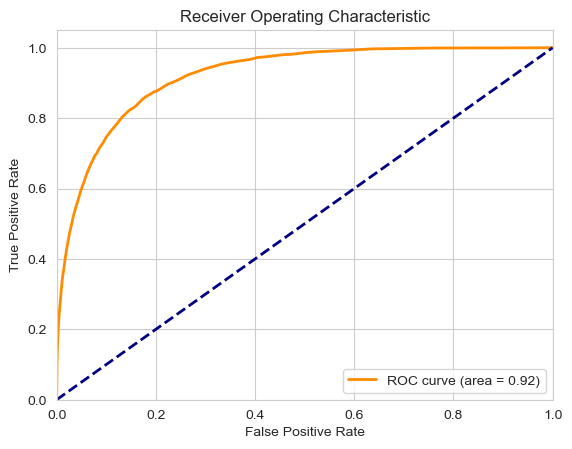

电磁辐射 (EMR) 模型评价指标:


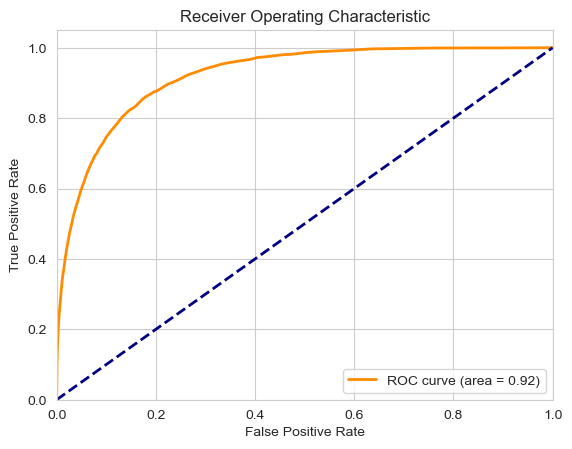

声波强度 (AE) 模型评价指标:


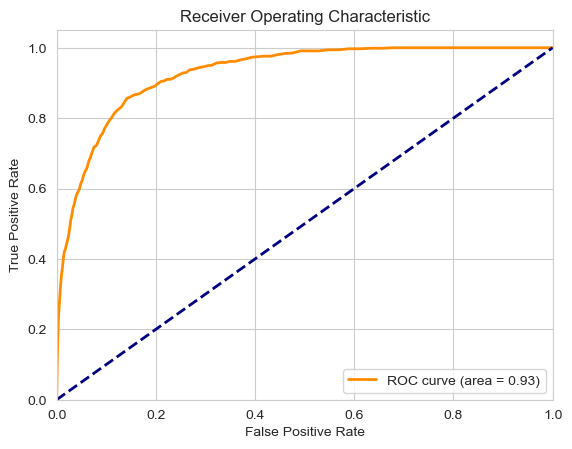

声波强度 (AE) 模型评价指标:


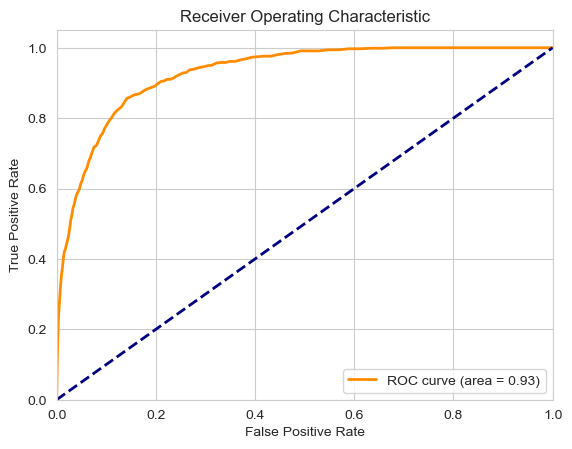

(RandomForestClassifier(random_state=42), SimpleImputer(), StandardScaler())

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

def train_and_return_model(features, target):
    # 分割数据为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

    # 创建一个填充实例并转换训练和测试数据
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # 应用欠采样
    rus = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train_imputed, y_train)

    # 数据标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test_imputed)

    # 构建随机森林模型
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # 训练模型
    clf.fit(X_train_scaled, y_train_resampled)

    # 在测试集上评估模型
    y_probs = clf.predict_proba(X_test_scaled)[:, 1]  # 获取正类的概率

    # 计算ROC曲线
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # 绘制ROC曲线
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return clf, imputer, scaler
X_emr = sheet1_features.drop(['前兆信号', '类别 (class)', '时间 (time)'], axis=1)
y_emr = sheet1_features['前兆信号']
print("电磁辐射 (EMR) 模型评价指标:")
train_and_return_model(X_emr, y_emr)
print("电磁辐射 (EMR) 模型评价指标:")
train_and_return_model(X_emr, y_emr)

X_ae = sheet2_features.drop(['前兆信号', '类别 (class)', '时间 (time)'], axis=1)
y_ae = sheet2_features['前兆信号']
# 假设 X_ae 和 y_ae 已经被定义
print("声波强度 (AE) 模型评价指标:")
train_and_return_model(X_ae, y_ae)
print("声波强度 (AE) 模型评价指标:")
train_and_return_model(X_ae, y_ae)


In [32]:
# 查看X_emr的列名
print(X_emr.columns)
print(EMR_df_processed.columns)

Index(['电磁辐射 (EMR)', 'rolling_mean', 'rolling_std', 'rolling_var', 'ewm_mean',
       'ewm_std', 'lag_1', 'lag_2', 'day_of_week', 'is_weekend', 'trend',
       'seasonality', 'long_rolling_mean', 'short_rolling_mean', 'diff_1',
       'diff_2'],
      dtype='object')
Index(['电磁辐射 (EMR)', '时间 (time)', 'rolling_mean', 'rolling_std', 'rolling_var',
       'ewm_mean', 'ewm_std', 'lag_1', 'lag_2', 'day_of_week', 'is_weekend',
       'trend', 'seasonality', 'long_rolling_mean', 'short_rolling_mean',
       'diff_1', 'diff_2'],
      dtype='object')


In [30]:
import pandas as pd
EMR_df = pd.read_excel("./附件3 (Attachment 3).xlsx", sheet_name='EMR',skiprows=1)
AE_df = pd.read_excel("./附件3 (Attachment 3).xlsx", sheet_name='AE', skiprows=1)
EMR_df = EMR_df.iloc[:,[0,1]]
EMR_df = EMR_df.dropna()
AE_df = AE_df.iloc[:,[0,1]]
AE_df = AE_df.dropna()
# EMR_df = EMR_df.rename(columns=lambda x: x.replace('.1', ''))
# AE_df = AE_df.rename(columns=lambda x: x.replace('.1', ''))

In [31]:
def calculate_features(data, value_col, window_size=3):
    features_df = pd.DataFrame()
    
    # 基本滚动窗口特征
    features_df['rolling_mean'] = data[value_col].rolling(window=window_size).mean()
    features_df['rolling_std'] = data[value_col].rolling(window=window_size).std()
    features_df['rolling_var'] = data[value_col].rolling(window=window_size).var()
    
    # 指数平滑特征
    features_df['ewm_mean'] = data[value_col].ewm(span=window_size).mean()
    features_df['ewm_std'] = data[value_col].ewm(span=window_size).std()
    
    # 拉格特征
    features_df['lag_1'] = data[value_col].shift(1)
    features_df['lag_2'] = data[value_col].shift(2)
    
    # 季节性特征 - 时间维度
    data['时间 (time)'] = pd.to_datetime(data['时间 (time)'])  # 确保时间列的数据类型为 datetime
    features_df['day_of_week'] = data['时间 (time)'].dt.weekday
    features_df['is_weekend'] = (features_df['day_of_week'] >= 5).astype(int)
    
    # 趋势特征
    features_df['trend'] = data[value_col].diff().rolling(window=window_size).mean()
    
    # 周期性特征
    features_df['seasonality'] = data[value_col].diff(7)  # 周期为7天
    
    # 窗口统计特征
    features_df['long_rolling_mean'] = data[value_col].rolling(window=7).mean()
    features_df['short_rolling_mean'] = data[value_col].rolling(window=3).mean()
    
    # 差分特征
    features_df['diff_1'] = data[value_col].diff()
    features_df['diff_2'] = data[value_col].diff().diff()
    
    # 连接原始数据和衍生特征
    features_df.index = data.index
    result = pd.concat([data, features_df], axis=1)
    return result
EMR_df_processed = calculate_features(EMR_df, value_col='电磁辐射 (EMR)')
AE_df_processed = calculate_features(AE_df, value_col='声波强度 (AE)')

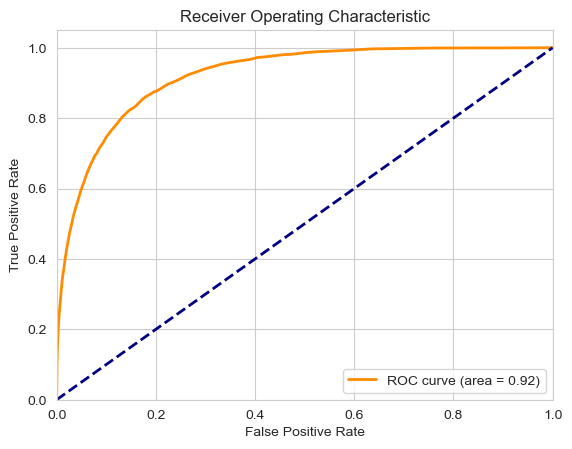

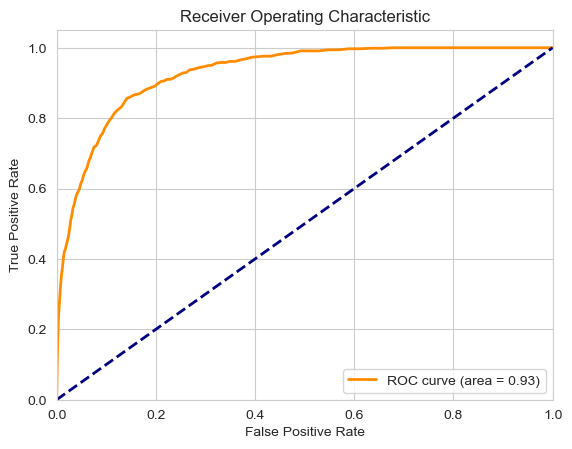

In [24]:
clf_emr, imputer_emr, scaler_emr = train_and_return_model(X_emr, y_emr)
clf_ae, imputer_ae, scaler_ae = train_and_return_model(X_ae, y_ae)


In [25]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# 假设已经创建了EMR_df_processed和AE_df_processed DataFrame，以及相关的clf_emr, clf_ae, imputer_emr, imputer_ae

# 转换时间列为 datetime 类型
EMR_df_processed['时间 (time)'] = pd.to_datetime(EMR_df_processed['时间 (time)'])
AE_df_processed['时间 (time)'] = pd.to_datetime(AE_df_processed['时间 (time)'])

# 保存时间列以备后用
EMR_times = EMR_df_processed['时间 (time)'].copy()
AE_times = AE_df_processed['时间 (time)'].copy()

# 预处理数据（移除时间列进行预测）
EMR_df_imputed = imputer_emr.transform(EMR_df_processed.drop(columns=['时间 (time)']))
AE_df_imputed = imputer_ae.transform(AE_df_processed.drop(columns=['时间 (time)']))

# 使用模型进行预测概率
EMR_probabilities = clf_emr.predict_proba(EMR_df_imputed)[:, 1]  # 获取前兆信号的概率
AE_probabilities = clf_ae.predict_proba(AE_df_imputed)[:, 1]  # 获取前兆信号的概率

# 将预测概率和预测结果加入数据框
EMR_df_processed['前兆信号'] = (EMR_probabilities > 0.5).astype(int)  # 使用阈值0.5将概率转换为二进制结果
EMR_df_processed['前兆信号概率'] = EMR_probabilities
AE_df_processed['前兆信号'] = (AE_probabilities > 0.5).astype(int)
AE_df_processed['前兆信号概率'] = AE_probabilities

# 将时间列加回数据框
EMR_df_processed['时间 (time)'] = EMR_times
AE_df_processed['时间 (time)'] = AE_times

# 进行预测和处理数据
def process_and_save_probabilities(df_processed, clf, imputer, filename):
    # 移除并保存时间列
    times = df_processed['时间 (time)'].copy()
    
    # 移除非训练时使用的列
    columns_to_use = df_processed.columns[df_processed.columns != '时间 (time)']
    columns_to_use = columns_to_use[~columns_to_use.isin(['前兆信号', '前兆信号概率'])]  # 确保只包含训练时用的特征
    df_imputed = imputer.transform(df_processed[columns_to_use])
    
    # 使用 predict_proba 获取概率，取正类的概率
    probabilities = clf.predict_proba(df_imputed)[:, 1]
    
    # 创建结果数据框
    results_df = pd.DataFrame({
        '时间 (time)': times,
        '前兆信号概率': probabilities
    })
    
    results_df.to_csv(filename, index=False)
    print(f"数据已保存至 '{filename}'.")

process_and_save_probabilities(EMR_df_processed, clf_emr, imputer_emr, 'EMR_probabilities时间段2 (time period 1).csv')
process_and_save_probabilities(AE_df_processed, clf_ae, imputer_ae, 'AE_probabilities时间段2 (time period 1).csv')


数据已保存至 'EMR_probabilities时间段2 (time period 1).csv'.
数据已保存至 'AE_probabilities时间段2 (time period 1).csv'.


### 特征工程

过程与问题2完全相同

### 模型预测和概率计算

在特征工程之后，使用分类模型来预测目标变量并计算属于特定类别的概率。

#### 模型建立和预测

计算样本属于正类的概率。

- **模型预测**：
  $$ \text{predictions} = \text{model}.predict(X_{\text{processed}}) $$

- **计算概率**（使用 Sigmoid 激活函数的神经网络模型）：
  $$ \text{probabilities} = \text{sigmoid}(\text{predictions}) $$

### 结果输出

将预测概率与实际观测值一起保存到新的数据框或输出文件中，以便进行后续分析或报告。

- **保存结果**：
  $$ \text{results\_df} = \text{pd.concat}([data, \text{pd.DataFrame}(\text{probabilities}, \text{columns}=['Probability'])], \text{axis}=1) $$
  $$ \text{results\_df}.to\_csv('final\_predictions.csv', \text{index}=False) $$



### 这个问的写作主要需要查找深度学习模型、用 Sigmoid 激活函数的神经网络模型计算概率